In [4]:
pip install -q numpy matplotlib tensorflow  librosa  soundfile numpy scikit-learn tensorflow-addons


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow-addons (from versions: none)
ERROR: No matching distribution found for tensorflow-addons

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
pip install tensorflow-addons



SyntaxError: invalid syntax (4142440932.py, line 1)

In [6]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [3]:
import os
import numpy as np
import librosa
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
#import tensorflow-addons as tfa

# ==== Configuration ====
DATA_DIRS = ["Audio_Song_Actors_01-24", "Audio_Speech_Actors_01-24"]
SAMPLE_RATE = 22050
N_MFCC = 40
MAX_LEN = 216  # longer padding for full clips

# ==== Feature Extraction ====
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC).T
    chroma = librosa.feature.chroma_stft(y=y, sr=sr).T
    zcr = librosa.feature.zero_crossing_rate(y).T
    rms_feature = librosa.feature.rms(y=y).T

    def pad(x):
        return x[:MAX_LEN] if x.shape[0] >= MAX_LEN else np.pad(x, ((0, MAX_LEN - x.shape[0]), (0, 0)), mode='constant')

    mfcc = pad(mfcc)
    chroma = pad(chroma)
    zcr = pad(zcr)
    rms_feature = pad(rms_feature)

    return np.concatenate([mfcc, chroma, zcr, rms_feature], axis=1)


X, y = [], []

# ==== Dataset Preparation ====
for data_dir in DATA_DIRS:
    for emotion_label in os.listdir(data_dir):
        subfolder_path = os.path.join(data_dir, emotion_label)
        if not os.path.isdir(subfolder_path):
            continue
        for file in os.listdir(subfolder_path):
            if file.endswith(".wav"):
                try:
                    path = os.path.join(subfolder_path, file)
                    features = extract_features(path)
                    X.append(features)
                    y.append(emotion_label)
                except Exception as e:
                    print(f"Error processing {file}: {e}")

X = np.array(X)

# ==== Balance Dataset ====
df = pd.DataFrame({'x': X.tolist(), 'y': y})
min_count = df['y'].value_counts().min()
balanced_df = df.groupby('y').apply(lambda g: g.sample(min_count, random_state=42)).reset_index(drop=True)

X_balanced = np.stack(balanced_df['x'].values)
y_balanced = balanced_df['y'].values

le = LabelEncoder()
y_encoded = le.fit_transform(y_balanced)
y_cat = to_categorical(y_encoded)
np.save("classes.npy", le.classes_)

# ==== Train-Validation Split ====
X_train, X_val, y_train, y_val = train_test_split(X_balanced, y_cat, test_size=0.2, stratify=y_cat, random_state=42)

# ==== Model Definition ====
model = Sequential([
    Conv1D(64, 5, activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(128, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(256, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_cat.shape[1], activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# ==== Callbacks ====
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.5, verbose=1)
]

# ==== Training ====
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=100, batch_size=32, callbacks=callbacks)

# ==== Save Model ====
model.save("trained_model.h5")

# ==== Evaluation ====


C:\Users\yashp\AppData\Local\Temp\ipykernel_1868\4000240062.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('y').apply(lambda g: g.sample(min_count, random_state=42)).reset_index(drop=True)
c:\Users\yashp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 216, 64)        │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 216, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 108, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 108, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 108, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 108, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 54, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 54, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 27, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 27, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6912)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,769,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,948,120 (7.43 MB)

 Trainable params: 1,947,224 (7.43 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.0577 - loss: 4.3928 - val_accuracy: 0.0660 - val_loss: 3.1435 - learning_rate: 0.0010
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.1090 - loss: 3.0465 - val_accuracy: 0.1215 - val_loss: 2.9423 - learning_rate: 0.0010
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.1457 - loss: 2.8289 - val_accuracy: 0.1910 - val_loss: 2.5961 - learning_rate: 0.0010
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.2630 - loss: 2.4973 - val_accuracy: 0.3681 - val_loss: 2.0702 - learning_rate: 0.0010
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.3278 - loss: 2.1575 - val_accuracy: 0.5451 - val_loss: 1.5827 - learning_rate: 0.0010
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.4037 - loss: 1.8978 - val_accuracy: 0.4375 - val_loss: 1.9903 - learning_rate: 0.0010
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.4856 - loss: 1.6401 - 

In [16]:
from sklearn.metrics import accuracy_score

for i, emotion in enumerate(le.classes_):
    idx = y_true_labels == i
    acc = accuracy_score(y_true_labels[idx], y_pred_labels[idx])
    if acc < 0.75:
        print(f"❌ {emotion}: {acc:.2%} (needs improvement)")


❌ Actor_07: 66.67% (needs improvement)
❌ Actor_20: 66.67% (needs improvement)


In [14]:
from sklearn.metrics import accuracy_score, f1_score

# Get true and predicted emotion class labels
y_true = np.argmax(y_val, axis=1)
y_pred = np.argmax(model.predict(X_val), axis=1)

# Emotion-wise accuracy
print("\n🎯 Emotion-wise Accuracy:")
for i, emotion in enumerate(le.classes_):
    indices = (y_true == i)
    class_acc = accuracy_score(y_true[indices], y_pred[indices])
    print(f"{emotion}: {class_acc:.2%} accuracy")

# Overall metrics
overall_acc = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average='macro')

print(f"\n✅ Overall Accuracy: {overall_acc:.2%}")
print(f"✅ Macro F1 Score: {macro_f1:.2%}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

🎯 Emotion-wise Accuracy:
Actor_01: 83.33% accuracy
Actor_02: 83.33% accuracy
Actor_03: 100.00% accuracy
Actor_04: 83.33% accuracy
Actor_05: 83.33% accuracy
Actor_06: 100.00% accuracy
Actor_07: 66.67% accuracy
Actor_08: 91.67% accuracy
Actor_09: 83.33% accuracy
Actor_10: 100.00% accuracy
Actor_11: 100.00% accuracy
Actor_12: 100.00% accuracy
Actor_13: 100.00% accuracy
Actor_14: 100.00% accuracy
Actor_15: 100.00% accuracy
Actor_16: 91.67% accuracy
Actor_17: 100.00% accuracy
Actor_18: 100.00% accuracy
Actor_19: 83.33% accuracy
Actor_20: 66.67% accuracy
Actor_21: 100.00% accuracy
Actor_22: 100.00% accuracy
Actor_23: 83.33% accuracy
Actor_24: 100.00% accuracy

✅ Overall Accuracy: 91.67%
✅ Macro F1 Score: 91.54%


In [15]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Get predicted labels
y_pred_labels = np.argmax(model.predict(X_val), axis=1)
y_true_labels = np.argmax(y_val, axis=1)

# Print emotion-wise accuracy
print("\n🎯 Emotion-wise Accuracy:")
for i, emotion in enumerate(le.classes_):
    idx = y_true_labels == i
    acc = accuracy_score(y_true_labels[idx], y_pred_labels[idx])
    print(f"{emotion}: {acc:.2%} accuracy")

# Final Metrics
overall_acc = accuracy_score(y_true_labels, y_pred_labels)
macro_f1 = f1_score(y_true_labels, y_pred_labels, average='macro')

print(f"\n✅ Overall Accuracy: {overall_acc:.2%}")
print(f"✅ Macro F1 Score: {macro_f1:.2%}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

🎯 Emotion-wise Accuracy:
Actor_01: 83.33% accuracy
Actor_02: 83.33% accuracy
Actor_03: 100.00% accuracy
Actor_04: 83.33% accuracy
Actor_05: 83.33% accuracy
Actor_06: 100.00% accuracy
Actor_07: 66.67% accuracy
Actor_08: 91.67% accuracy
Actor_09: 83.33% accuracy
Actor_10: 100.00% accuracy
Actor_11: 100.00% accuracy
Actor_12: 100.00% accuracy
Actor_13: 100.00% accuracy
Actor_14: 100.00% accuracy
Actor_15: 100.00% accuracy
Actor_16: 91.67% accuracy
Actor_17: 100.00% accuracy
Actor_18: 100.00% accuracy
Actor_19: 83.33% accuracy
Actor_20: 66.67% accuracy
Actor_21: 100.00% accuracy
Actor_22: 100.00% accuracy
Actor_23: 83.33% accuracy
Actor_24: 100.00% accuracy

✅ Overall Accuracy: 91.67%
✅ Macro F1 Score: 91.54%


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

✅ Classification Report:
              precision    recall  f1-score   support

    Actor_01       1.00      0.83      0.91        12
    Actor_02       0.91      0.83      0.87        12
    Actor_03       0.86      1.00      0.92        12
    Actor_04       1.00      0.83      0.91        12
    Actor_05       0.83      0.83      0.83        12
    Actor_06       1.00      1.00      1.00        12
    Actor_07       0.89      0.67      0.76        12
    Actor_08       0.92      0.92      0.92        12
    Actor_09       0.91      0.83      0.87        12
    Actor_10       0.92      1.00      0.96        12
    Actor_11       0.75      1.00      0.86        12
    Actor_12       0.80      1.00      0.89        12
    Actor_13       0.92      1.00      0.96        12
    Actor_14       1.00      1.00      1.00        12
    Actor_15       1.00      1.00      1.00        12
    Actor_16       1.00      0.92      0.96        12
    Actor_17     

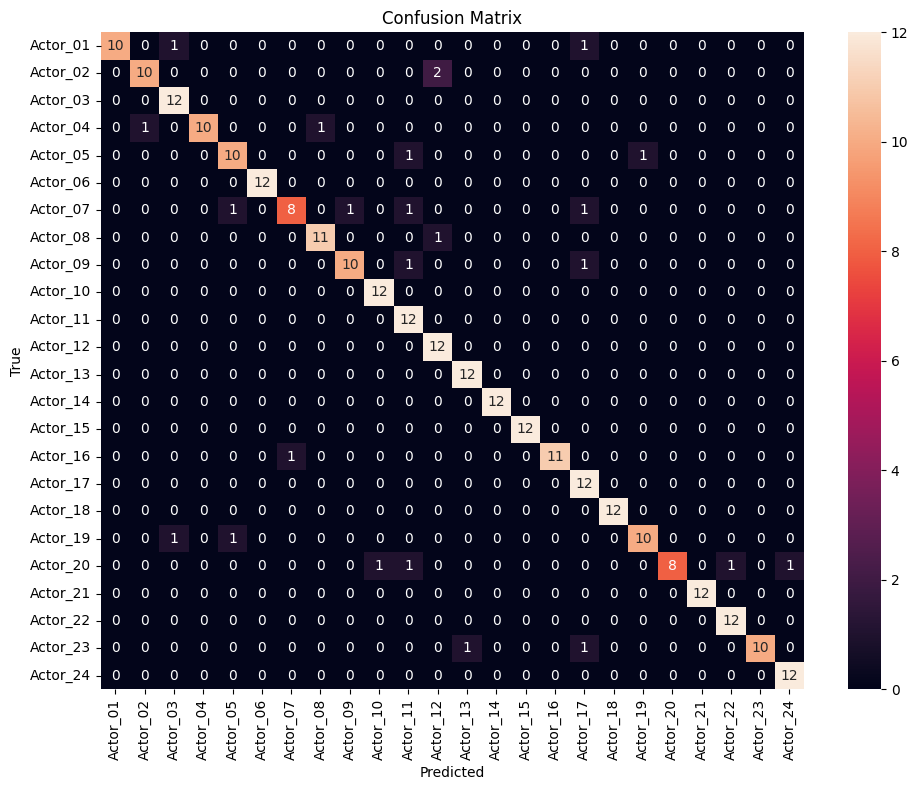

In [7]:
model.summary
model = load_model("trained_model.h5")
y_pred = model.predict(X_val)
y_val_labels = np.argmax(y_val, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

print("\n✅ Classification Report:")
print(classification_report(y_val_labels, y_pred_labels, target_names=le.classes_))

cm = confusion_matrix(y_val_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


C:\Users\yashp\AppData\Local\Temp\ipykernel_1868\3359572592.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  upsampled_df = grouped.apply(lambda g: g.sample(max_count, replace=True, random_state=42)).reset_index(drop=True)
c:\Users\yashp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 216, 64)        │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 216, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 108, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 108, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 108, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 108, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 54, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 54, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 27, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 27, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6912)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     1,769,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,948,120 (7.43 MB)

 Trainable params: 1,947,224 (7.43 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.0463 - loss: 4.1498 - val_accuracy: 0.0720 - val_loss: 3.1090 - learning_rate: 0.0010
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.0958 - loss: 3.0659 - val_accuracy: 0.1420 - val_loss: 2.8766 - learning_rate: 0.0010
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.1629 - loss: 2.7855 - val_accuracy: 0.3460 - val_loss: 2.2543 - learning_rate: 0.0010
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.2709 - loss: 2.3206 - val_accuracy: 0.4700 - val_loss: 1.7062 - learning_rate: 0.0010
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4205 - loss: 1.8109 - val_accuracy: 0.5440 - val_loss: 1.3385 - learning_rate: 0.0010
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.5201 - loss: 1.5143 - val_accuracy: 0.5340 - val_loss: 1.5402 - learning_rate: 0.0010
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.5935 - loss: 1.2667 - 

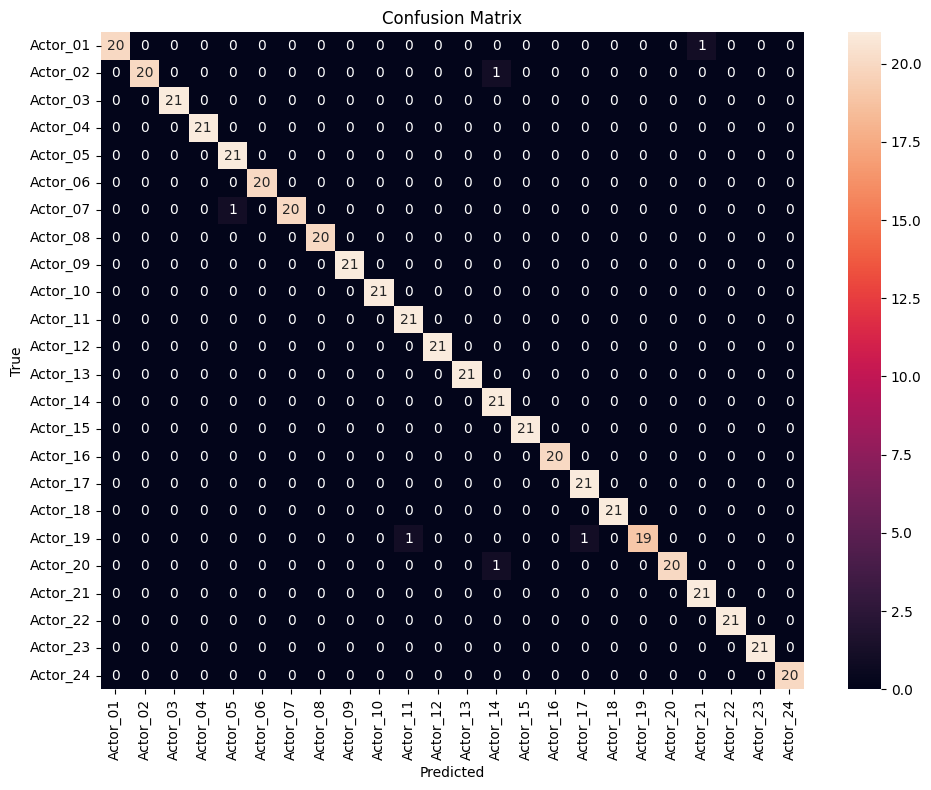

In [18]:
import os
import numpy as np
import librosa
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.utils import resample, compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# ==== Configuration ====
DATA_DIRS = ["Audio_Song_Actors_01-24", "Audio_Speech_Actors_01-24"]
SAMPLE_RATE = 22050
N_MFCC = 40
MAX_LEN = 216

# ==== Feature Extraction ====
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC).T
    chroma = librosa.feature.chroma_stft(y=y, sr=sr).T
    zcr = librosa.feature.zero_crossing_rate(y).T
    rms_feature = librosa.feature.rms(y=y).T

    def pad(x):
        return x[:MAX_LEN] if x.shape[0] >= MAX_LEN else np.pad(x, ((0, MAX_LEN - x.shape[0]), (0, 0)), mode='constant')

    mfcc = pad(mfcc)
    chroma = pad(chroma)
    zcr = pad(zcr)
    rms_feature = pad(rms_feature)

    return np.concatenate([mfcc, chroma, zcr, rms_feature], axis=1)

X, y = [], []

# ==== Dataset Preparation ====
for data_dir in DATA_DIRS:
    for emotion_label in os.listdir(data_dir):
        subfolder_path = os.path.join(data_dir, emotion_label)
        if not os.path.isdir(subfolder_path):
            continue
        for file in os.listdir(subfolder_path):
            if file.endswith(".wav"):
                try:
                    path = os.path.join(subfolder_path, file)
                    features = extract_features(path)
                    X.append(features)
                    y.append(emotion_label)
                except Exception as e:
                    print(f"Error processing {file}: {e}")

X = np.array(X)

# ==== Upsample to Balance Classes ====
df = pd.DataFrame({'x': X.tolist(), 'y': y})
grouped = df.groupby('y')
max_count = grouped.size().max()
upsampled_df = grouped.apply(lambda g: g.sample(max_count, replace=True, random_state=42)).reset_index(drop=True)

X_balanced = np.stack(upsampled_df['x'].values)
y_balanced = upsampled_df['y'].values

le = LabelEncoder()
y_encoded = le.fit_transform(y_balanced)
y_cat = to_categorical(y_encoded)
np.save("classes.npy", le.classes_)

# ==== Train-Validation Split ====
X_train, X_val, y_train, y_val = train_test_split(X_balanced, y_cat, test_size=0.2, stratify=y_cat, random_state=42)

# ==== Compute Class Weights ====
y_int = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_int), y=y_int)
class_weights = dict(enumerate(class_weights))

# ==== Model Definition ====
model = Sequential([
    Conv1D(64, 5, activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(128, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(256, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_cat.shape[1], activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# ==== Callbacks ====
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.5, verbose=1)
]

# ==== Training ====
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=100, batch_size=32, callbacks=callbacks, class_weight=class_weights)

# ==== Save Model ====
model.save("trained_model.keras")

# ==== Evaluation ====
y_pred = model.predict(X_val)
y_val_labels = np.argmax(y_val, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

print("\n✅ Classification Report:")
print(classification_report(y_val_labels, y_pred_labels, target_names=le.classes_))

# Emotion-wise accuracy
print("\n🎯 Emotion-wise Accuracy:")
for i, emotion in enumerate(le.classes_):
    idx = y_val_labels == i
    acc = accuracy_score(y_val_labels[idx], y_pred_labels[idx])
    status = "✅" if acc >= 0.75 else "❌"
    print(f"{status} {emotion}: {acc:.2%} accuracy")

# Overall metrics
overall_acc = accuracy_score(y_val_labels, y_pred_labels)
macro_f1 = f1_score(y_val_labels, y_pred_labels, average='macro')
print(f"\n✅ Overall Accuracy: {overall_acc:.2%}")
print(f"✅ Macro F1 Score: {macro_f1:.2%}")

# Confusion matrix
cm = confusion_matrix(y_val_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ==== Optional: Predict New File ====
def predict_emotion(filepath):
    model = load_model("trained_model.h5")
    classes = np.load("classes.npy")
    features = extract_features(filepath)
    features = np.expand_dims(features, axis=0)
    pred = model.predict(features)
    return classes[np.argmax(pred)]


In [19]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Get predicted labels
y_pred_labels = np.argmax(model.predict(X_val), axis=1)
y_true_labels = np.argmax(y_val, axis=1)

# Print emotion-wise accuracy
print("\n🎯 Emotion-wise Accuracy:")
for i, emotion in enumerate(le.classes_):
    idx = y_true_labels == i
    acc = accuracy_score(y_true_labels[idx], y_pred_labels[idx])
    print(f"{emotion}: {acc:.2%} accuracy")

# Final Metrics
overall_acc = accuracy_score(y_true_labels, y_pred_labels)
macro_f1 = f1_score(y_true_labels, y_pred_labels, average='macro')

print(f"\n✅ Overall Accuracy: {overall_acc:.2%}")
print(f"✅ Macro F1 Score: {macro_f1:.2%}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

🎯 Emotion-wise Accuracy:
Actor_01: 95.24% accuracy
Actor_02: 95.24% accuracy
Actor_03: 100.00% accuracy
Actor_04: 100.00% accuracy
Actor_05: 100.00% accuracy
Actor_06: 100.00% accuracy
Actor_07: 95.24% accuracy
Actor_08: 100.00% accuracy
Actor_09: 100.00% accuracy
Actor_10: 100.00% accuracy
Actor_11: 100.00% accuracy
Actor_12: 100.00% accuracy
Actor_13: 100.00% accuracy
Actor_14: 100.00% accuracy
Actor_15: 100.00% accuracy
Actor_16: 100.00% accuracy
Actor_17: 100.00% accuracy
Actor_18: 100.00% accuracy
Actor_19: 90.48% accuracy
Actor_20: 95.24% accuracy
Actor_21: 100.00% accuracy
Actor_22: 100.00% accuracy
Actor_23: 100.00% accuracy
Actor_24: 100.00% accuracy

✅ Overall Accuracy: 98.80%
✅ Macro F1 Score: 98.81%
